In [1]:
%load_ext autoreload
%autoreload 2

# load model

In [2]:
import argparse
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch import optim

In [3]:
from utils_DRD import get_repr_DTI

In [12]:
from data_tool_box_DRD import str2bool, load_pkl
# from DTI_meta_MAML_DRD import meta_DTI_MAML
from models_MAML0 import DTI_model_MAML

In [5]:
from transforms import FileTransform, TempReverseTransform,correlationReverseTransform

In [6]:
parser=argparse.ArgumentParser()
parser.add_argument('--frozen',default="none",type=str)
parser.add_argument('--cwd',default="../",type=str)
parser.add_argument('--batch_size',default=6,type=int)
parser.add_argument('--meta_lr',default=1e-3,type=float)
parser.add_argument('--global_MAML_step', default=20, type=int,
                    help='Number of global training steps, i.e. numberf of mini-batches ')
parser.add_argument('--val_range',default=26,type=int)
opt= parser.parse_args('')

In [7]:
args = {}
args.update(vars(opt))

In [16]:
train = pd.read_csv('../data/train_set.csv')

test=pd.read_csv('../data/test_set.csv')

In [13]:
model = DTI_model_MAML(all_config=args)
# .
# to('cuda')
tokenizer = model.prot_tokenizer
chem_dict = pd.Series(load_pkl( args['cwd']+'data/ChEMBLE26/chemical/ikey2smiles_ChEMBLE.pkl'))
protein_dict = pd.Series(load_pkl(args['cwd']+'data/ChEMBLE26/protein/unipfam2triplet.pkl'))

transform = FileTransform('../data/encodings/belu_26_tensor.pkl')
# result_transform=TempReverseTransform(args['val_range'])
result_transform=correlationReverseTransform(transform)

loaded DISAE :)


In [10]:
path='../exp_BEL_logs/exp19-07-2023-02-07-18/'

In [14]:
model.load_state_dict(torch.load(path+'BEL_model.dat'))

<All keys matched successfully>

# test set

In [27]:
from sklearn import metrics

In [19]:
model.eval()
print('---')

---


In [32]:
softmax = nn.Softmax(dim=1)

In [53]:
f1_scores=[]
for i in range(1000):

    # batch = test.sample(5)
    batch = train.sample(50)

    chem_graph, protein_tokenized = get_repr_DTI(batch, tokenizer, chem_dict, protein_dict, 'DISAE')

    # logit = model(protein_tokenized.to('cuda'),chem_graph.to('cuda'))
    logit = model(protein_tokenized,chem_graph)
    label = transform(batch['BEL-level'].values)
    level = torch.tensor(batch['BEL-level'].values)
    outp = result_transform.convert_continuous(logit.to('cuda'))

    s = softmax(logit)

#     s.shape
    score = metrics.f1_score(level.numpy(),outp.cpu().detach().numpy(),average='macro')
    f1_scores.append(score)

KeyboardInterrupt: 

In [57]:
np.mean(np.array(f1_scores))

0.0

In [42]:
# metrics.roc_auc_score(level.numpy(),s.detach().numpy(),multi_class='ovr',average='macro',labels=[1,3,5,6] )

# loss

In [6]:
from data_tool_box_DRD import load_pkl
import matplotlib.pyplot as plt

In [8]:
perform = load_pkl(path+'train_classic_performance.pkl')

In [9]:
len(perform['loss'])

177001

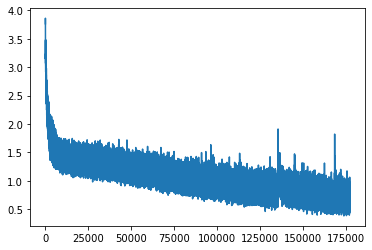

In [10]:
plt.plot(range(len(perform['loss'])), perform['loss'])